In [35]:
%matplotlib inline
from keras import backend as K
import numpy as np 
from matplotlib.pyplot import plot

In [126]:
n_way = 2
n_support,n_query = 3,2
emb_size =2

emb_np_raw = np.random.uniform(0,1,size=(n_way*(n_support+n_query),emb_size ) )
emb = K.identity(emb_np_raw)
#embemb_np_raw_l2 =K.eval( K.l2_normalize(emb,axis=1))
y_np = [i for i in range(n_way)]* n_support + [i for i in range(n_way)]*n_query
y = K.identity(y_np)
embemb_np_raw_l2=emb_np_raw

In [131]:
import tensorflow as tf 

def euc_distance(a,b):
    M2=b.shape[0]
    M1=a.shape[0]
    p1 = tf.matmul(tf.expand_dims(tf.reduce_sum(tf.square(a), 1), 1),tf.ones(shape=(1, M2),dtype=tf.float64) )
    p2 = tf.transpose(tf.matmul(tf.reshape(tf.reduce_sum(tf.square(b), 1), 
                                           shape=[-1, 1]),tf.ones(shape=(M1, 1),
                                           dtype=tf.float64),transpose_b=True))
    res = tf.add(p1, p2) - 2 * K.dot(a, K.transpose(b))
    return res


def euc_distance1(a,b):
    
    row_norms_A = tf.reduce_sum(tf.square(a), axis=1)
    row_norms_A = tf.reshape(row_norms_A, [-1, 1])  # Column vector.

    row_norms_B = tf.reduce_sum(tf.square(b), axis=1)
    row_norms_B = tf.reshape(row_norms_B, [1, -1])  # Row vector.

    return row_norms_A - 2 * tf.matmul(a, tf.transpose(b)) + row_norms_B

def proto_loss(emb,y_input):
    emb_s = emb[0:n_way*n_support,:]
    emb_q = emb[n_way*n_support:,:]    
    y_s = K.gather(y_input, [i for i in range(n_way*n_support)])
    y_q = K.gather(y_input, [i for i in range(n_way*n_support, n_way*(n_support+n_query)) ])
    
    onehot_s = K.cast(K.one_hot(y_s, n_way),'float64')
    centers = K.dot(K.transpose(onehot_s), emb_s)/n_support 
    dist_1=euc_distance1(emb_q,centers)
    onehot_q = K.cast(K.one_hot(y_q, n_way),'bool')
    loss_deno = K.logsumexp(-1 * dist_1,axis=1)
    loss_nume = tf.boolean_mask(dist_1, onehot_q)
    
    loss = K.mean(loss_nume + loss_deno)
    return loss 
    



In [128]:
import torch
from torch.nn import functional as F
from torch.nn.modules import Module

def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)


def prototypical_loss(input, target, n_support):
    '''
    Inspired by https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py
    Compute the barycentres by averaging the features of n_support
    samples for each class in target, computes then the distances from each
    samples' features to each one of the barycentres, computes the
    log_probability for each n_query samples for each one of the current
    classes, of appartaining to a class c, loss and accuracy are then computed
    and returned
    Args:
    - input: the model output for a batch of samples
    - target: ground truth for the above batch of samples
    - n_support: number of samples to keep in account when computing
      barycentres, for each one of the current classes
    '''
    target_cpu = target.to('cpu')
    input_cpu = input.to('cpu')

    def supp_idxs(c):
        # FIXME when torch will support where as np
        return target_cpu.eq(c).nonzero()[:n_support].squeeze(1)

    # FIXME when torch.unique will be available on cuda too
    classes = torch.unique(target_cpu)
    n_classes = len(classes)
    # FIXME when torch will support where as np
    # assuming n_query, n_target constants
    n_query = target_cpu.eq(classes[0].item()).sum().item() - n_support

    support_idxs = list(map(supp_idxs, classes))
    #print('support_idxs',support_idxs)
    prototypes = torch.stack([input_cpu[idx_list].mean(0) for idx_list in support_idxs])
    # FIXME when torch will support where as np
    #print(prototypes)
    query_idxs = torch.stack(list(map(lambda c: target_cpu.eq(c).nonzero()[n_support:], classes))).view(-1)
    #print('query_idxs',query_idxs)
    query_samples = input.to('cpu')[query_idxs]
    #print("prototypes",prototypes)
    #print("query_samples",query_samples)
    
    dists = euclidean_dist(query_samples, prototypes)
    #print("dists",dists)
    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)
    
    target_inds = torch.arange(0, n_classes)
    target_inds = target_inds.view(n_classes, 1, 1)
    target_inds = target_inds.expand(n_classes, n_query, 1).long()

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = y_hat.eq(target_inds.squeeze()).float().mean()

    return loss_val,  acc_val
l, a =prototypical_loss(torch.tensor(embemb_np_raw_l2),torch.tensor(y_np),n_support)
print(l.numpy().item())
print(K.eval(proto_loss(emb,y)))

0.7062270962917749
0.706227096291775


[-8.88178420e-16  3.33066907e-15  3.10862447e-15  0.00000000e+00
 -2.22044605e-16  4.44089210e-16 -2.22044605e-16  2.22044605e-16
  1.55431223e-15 -3.99680289e-15  3.33066907e-16  1.11022302e-16
  0.00000000e+00 -4.44089210e-16 -6.66133815e-16 -3.10862447e-15
  1.33226763e-15  5.55111512e-15  8.88178420e-16 -8.88178420e-16
 -2.22044605e-16 -8.88178420e-16  1.55431223e-15  0.00000000e+00
 -7.77156117e-16 -1.11022302e-15 -5.55111512e-16 -1.11022302e-15
 -2.22044605e-16 -1.11022302e-15  0.00000000e+00  1.11022302e-16
 -6.66133815e-16  1.11022302e-15 -1.55431223e-15 -6.66133815e-16
 -2.22044605e-16 -4.44089210e-16  5.55111512e-16 -4.44089210e-16
  3.33066907e-16  3.10862447e-15 -2.22044605e-16 -2.22044605e-16
  0.00000000e+00 -2.22044605e-16  8.88178420e-16  3.33066907e-16
 -2.22044605e-16  5.55111512e-16]
[39, 65, 86, 13, 75, 42, 54, 20, 63, 95, 33, 8, 62, 54, 39, 97, 43, 77, 89, 56, 46, 86, 48, 6, 54, 70, 48, 61, 28, 23, 49, 48, 34, 25, 37, 44, 12, 61, 43, 21, 36, 96, 30, 13, 39, 50, 49,

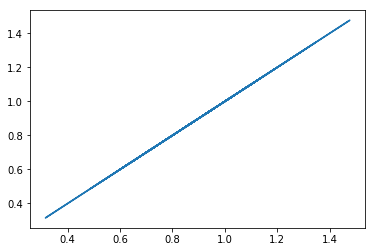

In [132]:
k =[]
p =[]
e=[]
for i in range(50):
    emb_size=np.random.randint(6,100)
    e.append(emb_size)
    emb_np_raw = np.random.uniform(0,1,size=(n_way*(n_support+n_query),emb_size ) )
    emb = K.identity(emb_np_raw)
    #embemb_np_raw_l2 =K.eval( K.l2_normalize(emb,axis=1))
    embemb_np_raw_l2=emb_np_raw
    y_np = [i for i in range(n_way)]* n_support + [i for i in range(n_way)]*n_query
    y = K.identity(y_np)
    k.append(K.eval(proto_loss(emb,y)))
    l, a =prototypical_loss(torch.tensor(embemb_np_raw_l2),torch.tensor(y_np),n_support)
    p.append(l.numpy().item())
    


print(np.array(k)-np.array(p))
print(e)
plot(k,p)